# Statistical models and PPL


## Bayesian Statistics in Climate and Weather

In Bayesian statistics, probability is viewed as a degree of belief of an event occurring (in contrast to frequentist statistics where probability is the frequency of an event occurring). The Bayesian view of probability is valuable in climate and weather forecasting. It allows us to quantify how likely we expect events to be, such as the probability of rain on a certain day.

In Bayesian statistics, we can incorporate a prior probability: our degree of belief of event occurring before observing any evidence. On an average day, we might expect rain to occur with some probability. We write the prior probability of rain as $P({\sf event})$. Then we observe some evidence and update our degree of belief about the event occurring. Let's say we look out the window and observe some data: we see there are many dark clouds in the sky.  So we can update our degree of belief of rain occurring this afternoon. This is called conditioning on observations. 

We write this updated probability as $P({\sf event}|{\sf obs})$. This is a conditional probability, or a probability of one event (rain) assuming that another event has occurred (cloud). In particular, we call this the posterior probability of rain, because we have observed some data (clouds) and updated our prior probability. We can use Bayes' theorem to calculate it:

$$P({\sf event}|{\sf obs}) \propto P({\sf obs}|{\sf event}) \times P({\sf event}) $$

There are two additional terms here. $P({\sf obs})$. is the evidence or the overall probability of seeing the cloud, regardless of whether it rains or not. $P({\sf obs}|{\sf event})$. is the likelihood, the probability of observing the data if you know the outcome, i.e. the probability of seeing the cloud if it ends up raining later. 

We are usually concerned with learning the posterior probability $P({\sf event}|{\sf obs})$, which is why Bayes' theorem is useful. But it can also be used more generally when we want to learn anything given some data, e.g. we might want to learn parameters of a model. This is called Bayesian inference.

This happens to be really useful and has many applications in climate and weather science. It becomes even more powerful when we think about probability distributions, which describe the probabilities associated with all the possible outcomes. One important use of Bayesian statistics is in data assimilation: incorporating observed data from satellites about the current state of the atmosphere into the weather model for prediction of the future state of the atmosphere.

## What is a probabilistic programming language (PPL)?

The traditional approach to constructing statistical models can be time-consuming and requires expertise. Typically it involves statisticians writing down the problem on paper and carrying out a mathematical procedure to design a bespoke statistical model. This would then be translated into code to construct a model ready for use. Since the model is specifically designed for the task at hand, this method must be repeated for each new problem.

Probabilistic programming languages are designed to make this process simpler, quicker and less technical. The idea is to remove the need for the expert statistician to hand-design the statistical model, by embedding this step within the programming language itself. Statistical tasks such as encoding observations (conditioning) and learning latent variables (inference) are automated and some of the complicated mathematical and statistical steps are hidden from the user. This makes statistical modelling more accessible to non-experts and tasks that traditionally require a lot of thought and hand-engineering can be automated.

## What does Probabalistic Programming involve? 

PPLs are just ordinary programming languages, equipped with tools that make statistical modelling easier for the user, reducing the need for hand-designing programs. The main components of a PPL are:

1) Sampling: Our model is probabilistic- it requires drawing values at random from probability distributions.

2) Conditioning: We have some observed data that can be used to update probabilities

3) Inference: We can learn something from the known data and model. This could be a "latent variable", some underlying factor that you can't directly observe but might influence the data. This is usually the hard part.

Probabilistic programming is a suitable choice when we have a probabalistic model, that relies on sampling from distributions in order to make predictions. PPL makes it easier to do conditioning on observed data and to learn something about the model. Note that probabilistic programming languages are not new. TThey have been around since Simula in 1966. However, with the rise of deep learning, they are growing in popularity, with many new PPLs designed with inference for machine learning in mind (e.g. Pyro, Edward, Infer.Net, webppl).

Let's look at a simple example to show how probabilistic programming works. We'll be using Pyro, a probabilistic programming language built on top of pytorch in python. Most of this example comes from the Introduction to Inference in Pyro tutorial.

## A simple model for a moving cloud

Let's say we have a cloud moving through the atmosphere with some speed in 1 dimension. We observe it after 10 seconds but with some measurement error. We want to use a probabilistic approach to find the distribution of the wind speed.

## 1) Statistical Model
The wind speed is something we can't directly observe- its a hidden variable. But we have some prior knowledge for what kind of wind speed to expect. We use this to sample from a prior distribution for the particle speed with a guess wind speed and variance. Then, the particle is moved a distance of speed x time and its final position is observed with some measurement error.

In [4]:
import numpy as np 
import torch
import pyro
import pyro.distributions as dist
np.random.seed(123)
def propagate_cloud(guess, guess_sd, time):
    """ Returns speed and observed position of cloud.
    guess = our initial guess for the speed of particle
    guess_sd = our guess for the standard deviation of the particle speed
    time = length of time before observing 
    """
    # sample from prior distribution
    speed = pyro.sample("speed", dist.Normal(guess, guess_sd))  
    position_final = speed * time
    # final position is observed with a bit of noise from our measurement tools
    position_observed = pyro.sample("position",dist.Normal(position_final, 10.))
    return(speed, position_observed)


The  `pyro.sample` statements are the first component of PPL, allowing us to sample from distributions. We provide pyro with unique names for each variable, so they can be tracked. We can run this model many times to find the distribution of particle speeds and observed positions.

In [2]:
import matplotlib.pyplot as plt
def plot_hist(hist1, hist2=None, title1="", title2="", true_dist=None):
    fig = plt.figure(figsize=(10,4))
    ax1 = plt.subplot2grid((1, 2), (0, 0));
    ax1.hist(hist1, 25, density=True, label="Guide", alpha=0.7);
    ax1.axvline(np.mean(hist1), c="k", ls="--");
    plt.title(title1);
    if hist2 is not None:
        ax2 = plt.subplot2grid((1, 2), (0, 1));
        ax2.hist(hist2, 25, density=True, label="Guide", alpha=0.7);
        ax2.axvline(np.mean(hist2), c="k", ls="--");
        plt.title(title2);
    if true_dist is not None:
        # Exact posterior distribution of speed: provide tuple for mu and sigma
        exact_mu,exact_sigma =  true_dist
        x = np.linspace(-5., 15., 100);
        f = 1./(exact_sigma*np.sqrt(2*np.pi))*np.exp(-(x-exact_mu)**2/(2*exact_sigma**2))
        for ax in fig.axes:
            ax.plot(x, f, lw=2, label="Exact", color="red");
            ax.axvline(exact_mu, ls="--", color="red");
            ax.legend();

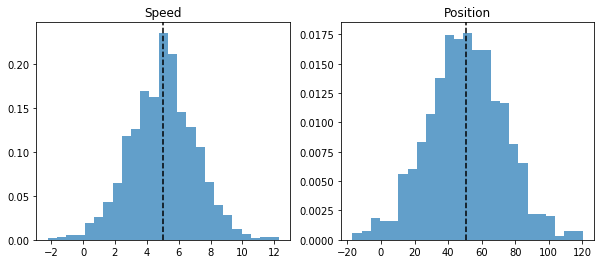

In [5]:
uncond = [propagate_cloud(guess=5., guess_sd=2., time=10.) for i in range(1000)]
speed_uncond, pos_uncond = zip(*uncond)
plot_hist(speed_uncond, pos_uncond, "Speed", "Position")

## 2) Conditioning

What if we observe the particle at a certain point, x=30 m? We want to use this information in our model to learn more about the latent variable, speed. This is when we condition on our observations.
In pyro, this is done with the pyro.condition statement. This statement returns a new function almost identical to the original, but overwrites the   `pyro.sample("position",...)` by fixing it at the observed value.

In [6]:
position_observed = 30
conditioned_propagate = pyro.condition(propagate_cloud,
                                       data={"position": position_observed})

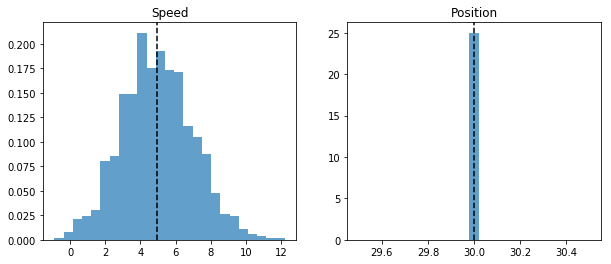

In [14]:
cond = [conditioned_propagate(guess=5., guess_sd=2., time=10.) for i in range(1000)]
speed_cond, pos_cond = zip(*cond)
plot_hist(speed_cond, pos_cond, "Speed", "Position")

## 3) Inference
The next step is inference- the difficult part. The aim is to find the posterior distribution of the speed, given our model and observation above.
$$P({\sf speed}|{\sf position}=30) \sim \, ?$$
Being able to calculate this exactly is rare, so we will estimate the distribution, we can use the stochastic variational inference algorithm. This requires a distribution called a guide (or variational distribution) that is an approximation the posterior distribution we want to know: $P({\sf speed}|{\sf position}=30)$. The guide relies on additional parameters that will be tuned to "guide" it towards the posterior distribution.

For this example, we will sample the wind speed from a normal distribution with mean and variance given by the new parameters, a and b. These are first defined with the statement pyro.param(...) and are stored in the "Pyro Parameter Store". The values we provide here for a and b aren't too important, as we will optimise these in the next step.

For this example, we will sample the wind speed from a normal distribution with mean and variance given by the new parameters, a and b. These are first defined with the statement `pyro.param(...)` and are stored in the "Pyro Parameter Store". The values we provide here for a and b aren't too important, as we will optimise these in the next step.

In [15]:
from torch.distributions import constraints
def guide(guess, guess_sd, time):
    """ The guide (or variational distribution) approximates 
    the posterior distribution, using extra variational parameters,
    a and b, to sample from the speed distribution. """
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(guess_sd), constraint=constraints.positive)
    speed = pyro.sample("speed", dist.Normal(a, b))
    return speed

We can check the distribution of the guide before optimising a and b. In our simple example we can actually calculate the exact posterior distribution using rules of normal distributions, to find that posterior distribution of the cloud speed has a mean of 3.4 m/s with a standard deviation of 0.89 m/s, shown in red above. Our initial guess is far from the ground truth.

In [16]:
speed_obs_mean = 30./10.
speed_obs_sd = 10./10.
guess = 5.
guess_sd = 2.
exact_mean = (speed_obs_sd**2 * guess + guess_sd**2 * speed_obs_mean)/(speed_obs_sd**2 + guess_sd**2) 
exact_sd = np.sqrt(guess_sd**2/((guess_sd**2 + speed_obs_sd**2)))

print("Exact Mean = {:.2f}, Exact Standard Deviation = {:.2f}".format(
    exact_mean, exact_sd))

Exact Mean = 3.40, Exact Standard Deviation = 0.89


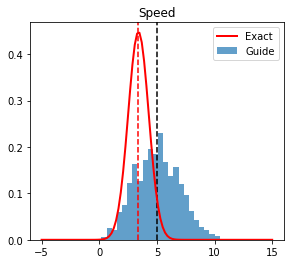

In [17]:
# Distribution of guide before any optimisation
speed_guide = [guide(guess=5., guess_sd=2., time=10.).item() for i in range(1000)]
plot_hist(speed_guide, title1="Speed", true_dist=(3.4, 0.89))

### Stochastic Variational Inference
Next we want to optimise the guide function to get a the best approximation to the posterior distribution, according to some loss function- we'll use the Evidence Lower Bound Operator or "ELBO" (link to why). We use stochastic variational inference , `pyro.infer.SVI` :

In [18]:
%%time 
pyro.clear_param_store()
import pyro.infer
import pyro.optim 
adam_params = {"lr": 0.001, "betas": (0.90, 0.999)}
optimizer = pyro.optim.Adam(adam_params)
svi = pyro.infer.SVI(model=conditioned_propagate, 
                     guide=guide,
                     optim=optimizer,
                     loss=pyro.infer.Trace_ELBO())

losses, a, b  = [], [], []
num_steps = 20000
for t in range(num_steps):
    losses.append(svi.step(guess=5., guess_sd=2., time=10.))
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())

CPU times: user 31.7 s, sys: 628 ms, total: 32.3 s
Wall time: 34.2 s


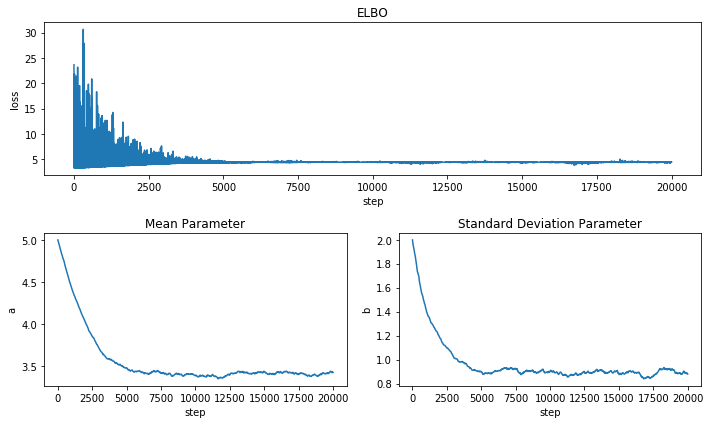

In [19]:
fig = plt.figure(figsize=(10,6));
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2);
ax1.plot(losses);
ax1.set(xlabel="step", ylabel="loss", title="ELBO");
ax2 = plt.subplot2grid((2, 2), (1, 0));
ax2.plot(a);
ax2.set(xlabel="step", ylabel="a", title="Mean Parameter");
ax3 = plt.subplot2grid((2, 2), (1, 1));
ax3.plot(b);
ax3.set(xlabel="step", ylabel="b", title="Standard Deviation Parameter");
plt.tight_layout();

Now this has converged, we can use the optimised values of `a` and `b` to sample from the guide. We can also compare this to the analytic speed, which can be calculated for this simple example:

In [20]:
print("Mean = {:.2f}, Standard Deviation = {:.2f}".format(np.mean(a[10000:20000]),np.mean(b[10000:20000])))

Mean = 3.40, Standard Deviation = 0.89


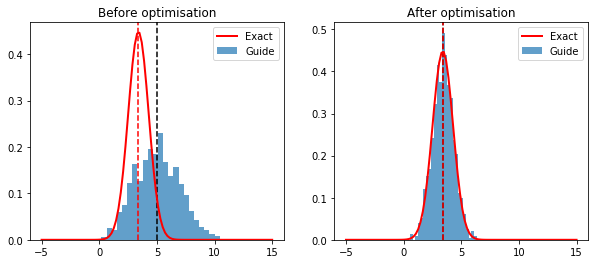

In [21]:
#Distribution of guide after optimisation
new_speed_guide = [guide(guess=5., guess_sd=2., time=10.).item() for i in range(1000)]
plot_hist(speed_guide, new_speed_guide, "Before optimisation", "After optimisation",
          true_dist=(3.4,0.89))

The result is that after optimisation, the distribution of the guide looks almost identical to the exact posterior. So we have a good approximation to the posterior distribution which we can easily draw samples from.

This example used stochastic variational inference, which gives us a way to approximate a posterior distribution, but we could have used Markov Chain Monte Carlo to learn a posterior distribution exactly at a higher computational cost.